In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,   ConfusionMatrixDisplay, precision_recall_curve 
from sklearn.inspection import permutation_importance
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Loading

#### Read data 

In [5]:
#Load dataset
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [7]:
df.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Understanding Features

In [9]:
# understanding features and making a list of categorical and numerical features
categorical_columns = ["education","marital","job","contact","day_of_week","poutcome","default","housing","loan", "month"]
numerical_columns = ["age","duration","campaign","pdays","previous","emp.var.rate","cons.price.idx","cons.conf.idx","euribor3m","nr.employed"]

In [10]:
#Converting yes/no to 1/0
df["y"] = df["y"].map({'yes': 1, 'no': 0})

In [11]:
# Encode categorical features for Lasso analysis
encoded_df = df.copy()
for col in categorical_columns:
    encoded_df[col] = LabelEncoder().fit_transform(encoded_df[col])

# Split the dataset into training and testing sets for evaluation
X_train, X_test, y_train, y_test= train_test_split(encoded_df.drop(columns=["y"]), encoded_df["y"], random_state=42)

#Define model
lasso_model = Lasso()

#Train the model
lasso_model.fit(X_train, y_train)

#Identify important features
lasso_pi = permutation_importance(lasso_model, X_test, y_test, scoring='neg_mean_squared_error', n_repeats=5, random_state=21)

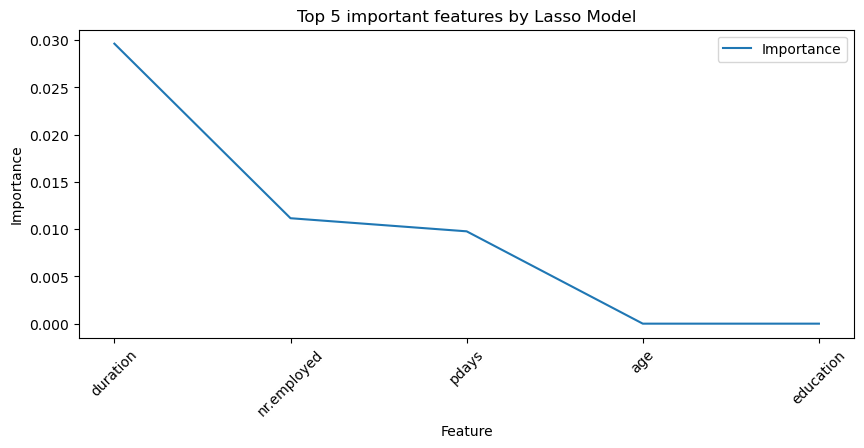

In [12]:
# Create a DataFrame
lasso_importance_df = pd.DataFrame({
                    'Feature': X_test.columns,
                    'Importance': lasso_pi.importances_mean
                    }).sort_values(by='Importance', ascending=False)
lasso_importance_df = lasso_importance_df.set_index("Feature")[0:5]

# Generate visualization of importance features
plt.figure(figsize=(10,4))
sns.lineplot(lasso_importance_df)
plt.title("Top 5 important features by Lasso Model")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.xticks(rotation=45) 
plt.show()

## Modelling

### Modelling with deafult settings

In [15]:
# Defining the column transformer to handle categorical data and scale numerical data
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), numerical_columns)
    ]
)

#Dataframes to capture results for comparison
basemodel_df = pd.DataFrame(columns = ["Model", "Train Time", "Train Accuracy", "Test Accuracy"])

#### Logistic Regression


In [17]:
#Logistic Regression Modeling use default settings
lgr = LogisticRegression(max_iter=1000, random_state=21)

#Build Pipeline
lgr_pipe = Pipeline([
         ("preprocessor", preprocessor),
         ("model",lgr)])

#GridSearch with no params, this will help us with model fit time
#train the model
lgr_grid = GridSearchCV(estimator=lgr_pipe, param_grid={}).fit(X_train, y_train)


In [18]:
#Adding results to dataframe to compare
lgr_results = ["Logistic Regression", round(lgr_grid.cv_results_['mean_fit_time'].mean(),6),
round(lgr_grid.best_estimator_.score(X_train, y_train),6),
round(lgr_grid.best_estimator_.score(X_test, y_test),6)]

basemodel_df.loc[len(basemodel_df)] =  lgr_results
basemodel_df

,Model,Train Time,Train Accuracy,Test Accuracy
0,Logistic Regression,0.037511,0.908776,0.909974


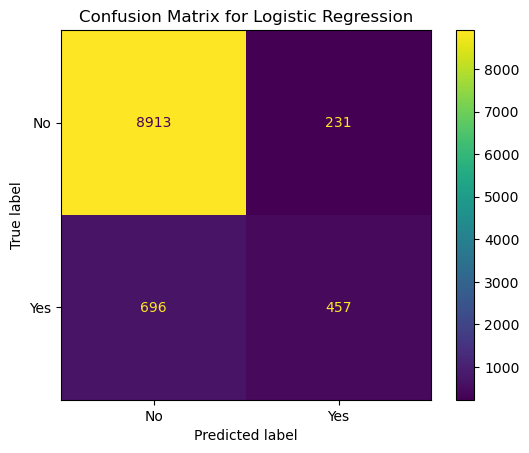

In [19]:
# Confusion Matrix Visualization
y_pred = lgr_grid.best_estimator_.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(conf_matrix, display_labels=["No","Yes"])
cm_display.plot()
plt.title("Confusion Matrix for Logistic Regression")
plt.show()

#### k-nearest neighbors(KNN) algorithm

In [21]:
# KNN modeling with default settings
knn_pipe = Pipeline([
         ("preprocessor", preprocessor),
         ("knn",KNeighborsClassifier())])

#Train the model
knn_grid = GridSearchCV(estimator=knn_pipe, param_grid={}).fit(X_train, y_train)


In [22]:
#Adding results to dataframe to compare
knn_results = ["KNN", round(knn_grid.cv_results_['mean_fit_time'].mean(),6),
round(knn_grid.best_estimator_.score(X_train, y_train),6),
round(knn_grid.best_estimator_.score(X_test, y_test),6)]

basemodel_df.loc[len(basemodel_df)] =  knn_results
basemodel_df

,Model,Train Time,Train Accuracy,Test Accuracy
0,Logistic Regression,0.037511,0.908776,0.909974
1,KNN,0.024037,0.931404,0.901428


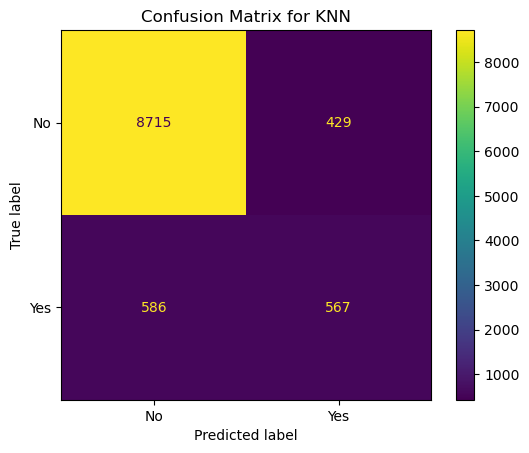

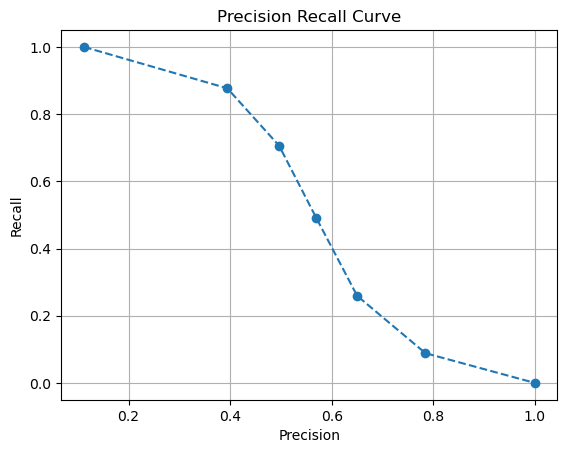

In [23]:
# Predictions 
y_pred = knn_grid.best_estimator_.predict(X_test)
y_preds_probs= knn_grid.best_estimator_.predict_proba(X_test)

#Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
cm_display =ConfusionMatrixDisplay(conf_matrix, display_labels=["No","Yes"])
cm_display.plot()
plt.title("Confusion Matrix for KNN")
plt.show()

#Precision Recall curve
precision, recall, boundaries = precision_recall_curve(y_true=y_test, probas_pred=y_preds_probs[:, 1])
plt.plot(precision, recall, '--o')
plt.grid()
plt.ylabel('Recall')
plt.xlabel('Precision')
plt.title('Precision Recall Curve');
plt.show()

#### Decision Tree

In [25]:
#Decision Tree modelling with default settings
dtc_pipe = Pipeline([
         ("preprocessor", preprocessor),
         ("dtc",DecisionTreeClassifier())])

#Training the model
dtc_grid = GridSearchCV(estimator=dtc_pipe, param_grid={}).fit(X_train, y_train)


In [26]:
#Adding results to dataframe to compare
dtc_results = ["Decision Tree", round(dtc_grid.cv_results_['mean_fit_time'].mean(),6),
round(dtc_grid.best_estimator_.score(X_train, y_train),6),
round(dtc_grid.best_estimator_.score(X_test, y_test),6)]

basemodel_df.loc[len(basemodel_df)] =  dtc_results
basemodel_df

,Model,Train Time,Train Accuracy,Test Accuracy
0,Logistic Regression,0.037511,0.908776,0.909974
1,KNN,0.024037,0.931404,0.901428
2,Decision Tree,0.068089,0.999903,0.888414


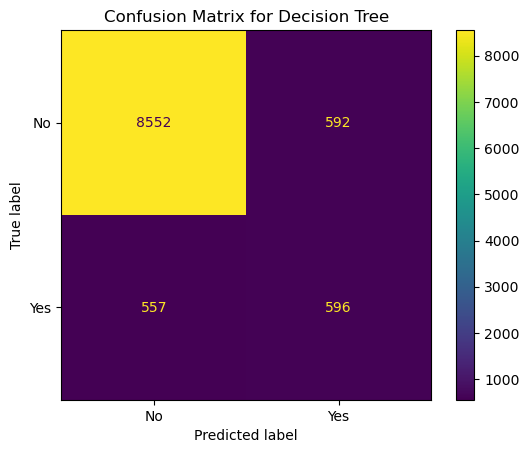

In [27]:
# Confusion Matrix
y_pred = dtc_grid.best_estimator_.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
cm_display =ConfusionMatrixDisplay(conf_matrix, display_labels=["No","Yes"])
cm_display.plot()
plt.title("Confusion Matrix for Decision Tree")
plt.show()


#### Support Vector Machine (SVM) 

In [29]:
# SVM modelling with default settings
svc_pipe = Pipeline([
         ("preprocessor", preprocessor),
         ("svc",SVC())])

#Train the model
svc_grid = GridSearchCV(estimator=svc_pipe, param_grid={}).fit(X_train, y_train)

In [30]:
#Adding results to dataframe to compare
svc_results = ["SVM", round(svc_grid.cv_results_['mean_fit_time'].mean(),6),
round(svc_grid.best_estimator_.score(X_train, y_train),6),
round(svc_grid.best_estimator_.score(X_test, y_test),6)]

basemodel_df.loc[len(basemodel_df)] =  svc_results
basemodel_df

,Model,Train Time,Train Accuracy,Test Accuracy
0,Logistic Regression,0.037511,0.908776,0.909974
1,KNN,0.024037,0.931404,0.901428
2,Decision Tree,0.068089,0.999903,0.888414
3,SVM,5.429129,0.912305,0.909780


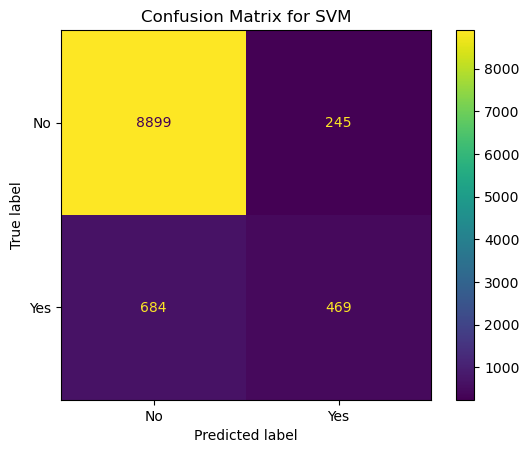

In [31]:
# Confusion Matrix Visualization
y_pred = svc_grid.best_estimator_.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
cm_display =ConfusionMatrixDisplay(conf_matrix, display_labels=["No","Yes"])
cm_display.plot()
plt.title("Confusion Matrix for SVM")
plt.show()


## Comparison of Model Results

In [33]:
#Changing the index
basemodel_df.set_index("Model", inplace=True)

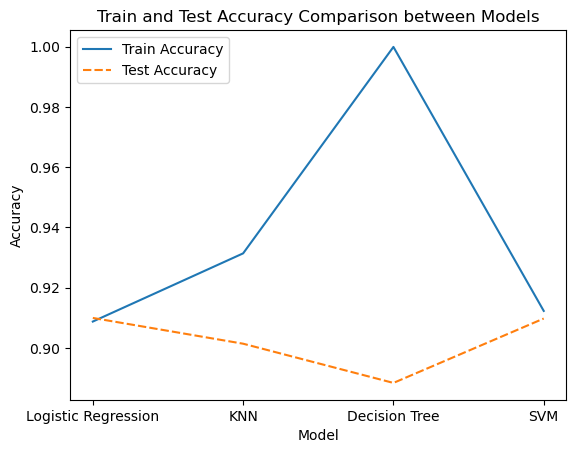

In [34]:
#Comparison Visualization
fig = sns.lineplot(data=basemodel_df.drop(columns="Train Time"))
plt.title("Train and Test Accuracy Comparison between Models")
plt.ylabel("Accuracy")
plt.show()

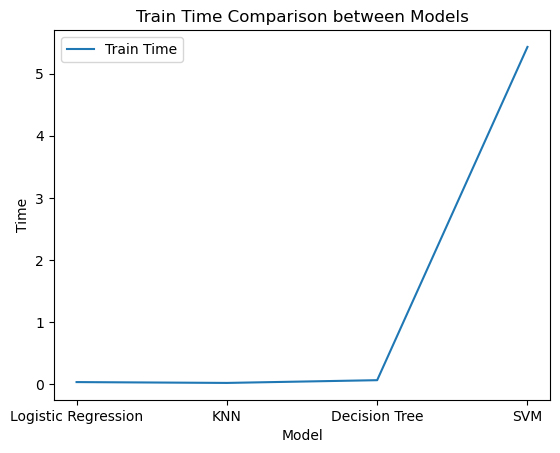

In [35]:
#Comparison Visualization
fig = sns.lineplot(data=basemodel_df[["Train Time"]])
plt.title("Train Time Comparison between Models")
plt.ylabel("Time")
plt.show()

### Improving models

Limited number of features, hyperparameter tuning and Grid Search

In [38]:
#Dataframes to capture results for comparison
improvedmodel_df = pd.DataFrame(columns = ["Model", "Train Time", "Train Accuracy", "Test Accuracy"])

In [39]:
#Columns chosen to remove
columns_to_drop = ["y","duration","emp.var.rate","cons.price.idx","cons.conf.idx","euribor3m", "nr.employed"]

In [40]:
# Optimized features list

# Split the dataset into training and testing sets for evaluation without duration
X_train, X_test, y_train, y_test= train_test_split(encoded_df.drop(columns=columns_to_drop), encoded_df["y"], random_state=42)

#removing columns 
for c  in columns_to_drop:
    if c in numerical_columns:
        numerical_columns.remove(c)

# Defining the column transformer to handle categorical data and scale numerical data
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), numerical_columns)
    ]
)

In [41]:
#Define model
lasso_model = Lasso()

#Train the model
lasso_model.fit(X_train, y_train)

#Identify important features
lasso_pi = permutation_importance(lasso_model, X_test, y_test, scoring='neg_mean_squared_error', n_repeats=5, random_state=21)

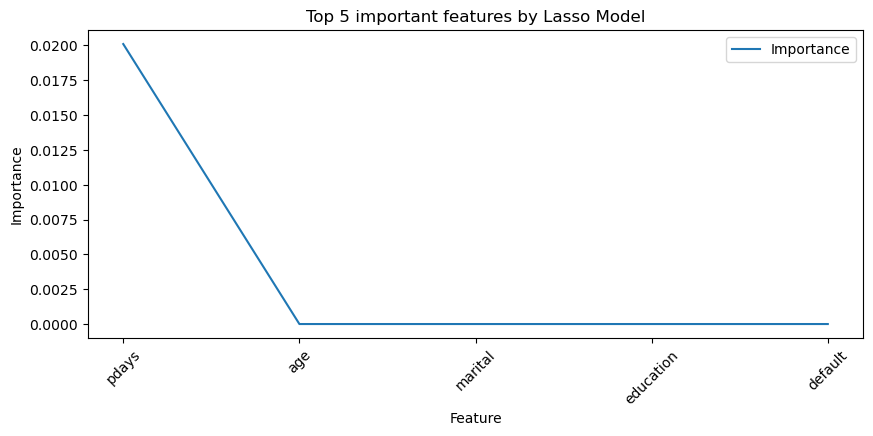

In [42]:
# Create a DataFrame
lasso_importance_df = pd.DataFrame({
                    'Feature': X_test.columns,
                    'Importance': lasso_pi.importances_mean
                    }).sort_values(by='Importance', ascending=False)
lasso_importance_df = lasso_importance_df.set_index("Feature")[0:5]

# Generate visualization of importance features
plt.figure(figsize=(10,4))
sns.lineplot(lasso_importance_df)
plt.title("Top 5 important features by Lasso Model")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.xticks(rotation=45) 
plt.show()

#### Logistic Regression

In [44]:
#Logistic Regression modelling with Grid Search 
lgr = LogisticRegression(max_iter=1000, random_state=21)
lgr_pipe = Pipeline([
         ("preprocessor", preprocessor),
         ("model",lgr)])

lgr_grid = GridSearchCV(estimator=lgr_pipe, param_grid={}).fit(X_train, y_train)


In [45]:
#Adding results to dataframe to compare
lgr_results = ["Logistic Regression", round(lgr_grid.cv_results_['mean_fit_time'].mean(),6),
round(lgr_grid.best_estimator_.score(X_train, y_train),6),
round(lgr_grid.best_estimator_.score(X_test, y_test),6)]

improvedmodel_df.loc[len(improvedmodel_df)] =  lgr_results
improvedmodel_df

,Model,Train Time,Train Accuracy,Test Accuracy
0,Logistic Regression,0.016275,0.897996,0.896863


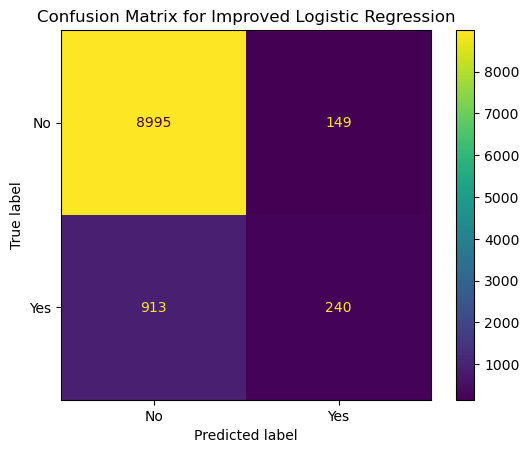

In [46]:
# Confusion Matrix for Visualization
y_pred = lgr_grid.best_estimator_.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
cm_display =ConfusionMatrixDisplay(conf_matrix, display_labels=["No","Yes"])
cm_display.plot()
plt.title("Confusion Matrix for Improved Logistic Regression")
plt.show()

#### k-nearest neighbors(KNN) algorithm

In [48]:
#KNN modeling with Grid Search
params = {"knn__n_neighbors":list(i for i in range(10, 23,1))}
knn_pipe = Pipeline([
         ("preprocessor", preprocessor),
         ("knn",KNeighborsClassifier())])

knn_grid = GridSearchCV(estimator=knn_pipe, param_grid=params).fit(X_train, y_train)


In [49]:
print(f'Best number of Neighbors : {knn_grid.best_params_}')
#Adding results to compare
knn_results = ["KNN", round(knn_grid.cv_results_['mean_fit_time'].mean(),6),
round(knn_grid.best_estimator_.score(X_train, y_train),6),
round(knn_grid.best_estimator_.score(X_test, y_test),6)]

improvedmodel_df.loc[len(improvedmodel_df)] =  knn_results
improvedmodel_df

Best number of Neighbors : {'knn__n_neighbors': 11}


,Model,Train Time,Train Accuracy,Test Accuracy
0,Logistic Regression,0.016275,0.897996,0.896863
1,KNN,0.015870,0.900165,0.894630


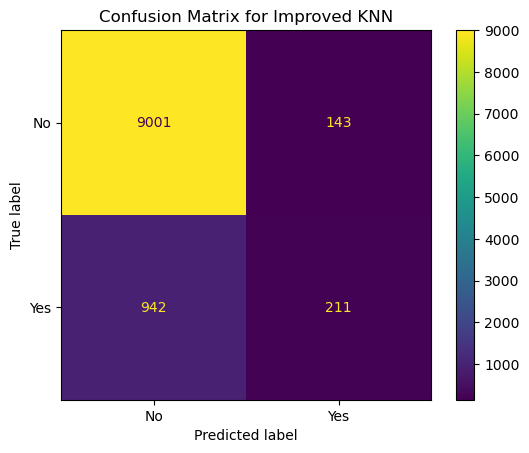

In [50]:
# Confusion Matrix
y_pred = knn_grid.best_estimator_.predict(X_test)
y_preds_probs = knn_grid.best_estimator_.predict_proba(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
cm_display =ConfusionMatrixDisplay(conf_matrix, display_labels=["No","Yes"])
cm_display.plot()
plt.title("Confusion Matrix for Improved KNN")
plt.show()

#### Decision Tree

In [52]:
#Decision Tree modeling with Grid Search
options = list(range(1 , 10, 2))
params = {
            'dtc__max_depth': options,
            'dtc__min_samples_split': options[1:],
            'dtc__criterion': ["gini"],
            'dtc__min_samples_leaf': options[1:]
         }

#Build Pipeline
dtc_pipe = Pipeline([
         ("preprocessor", preprocessor),
         ("dtc",DecisionTreeClassifier())])

# Modeling with GridSearch and train
dtc_grid = GridSearchCV(estimator=dtc_pipe, param_grid=params).fit(X_train, y_train)


In [53]:
print(f'Best params for Decision Tree :\n {dtc_grid.best_params_}')
#Add results to dataframe for comparison
dtc_results = ["Decision Tree", round(dtc_grid.cv_results_['mean_fit_time'].mean(),6),
round(dtc_grid.best_estimator_.score(X_train, y_train),6),
round(dtc_grid.best_estimator_.score(X_test, y_test),6)]

improvedmodel_df.loc[len(improvedmodel_df)] =  dtc_results
improvedmodel_df

Best params for Decision Tree :
 {'dtc__criterion': 'gini', 'dtc__max_depth': 1, 'dtc__min_samples_leaf': 3, 'dtc__min_samples_split': 3}


,Model,Train Time,Train Accuracy,Test Accuracy
0,Logistic Regression,0.016275,0.897996,0.896863
1,KNN,0.015870,0.900165,0.894630
2,Decision Tree,0.015409,0.897834,0.896572


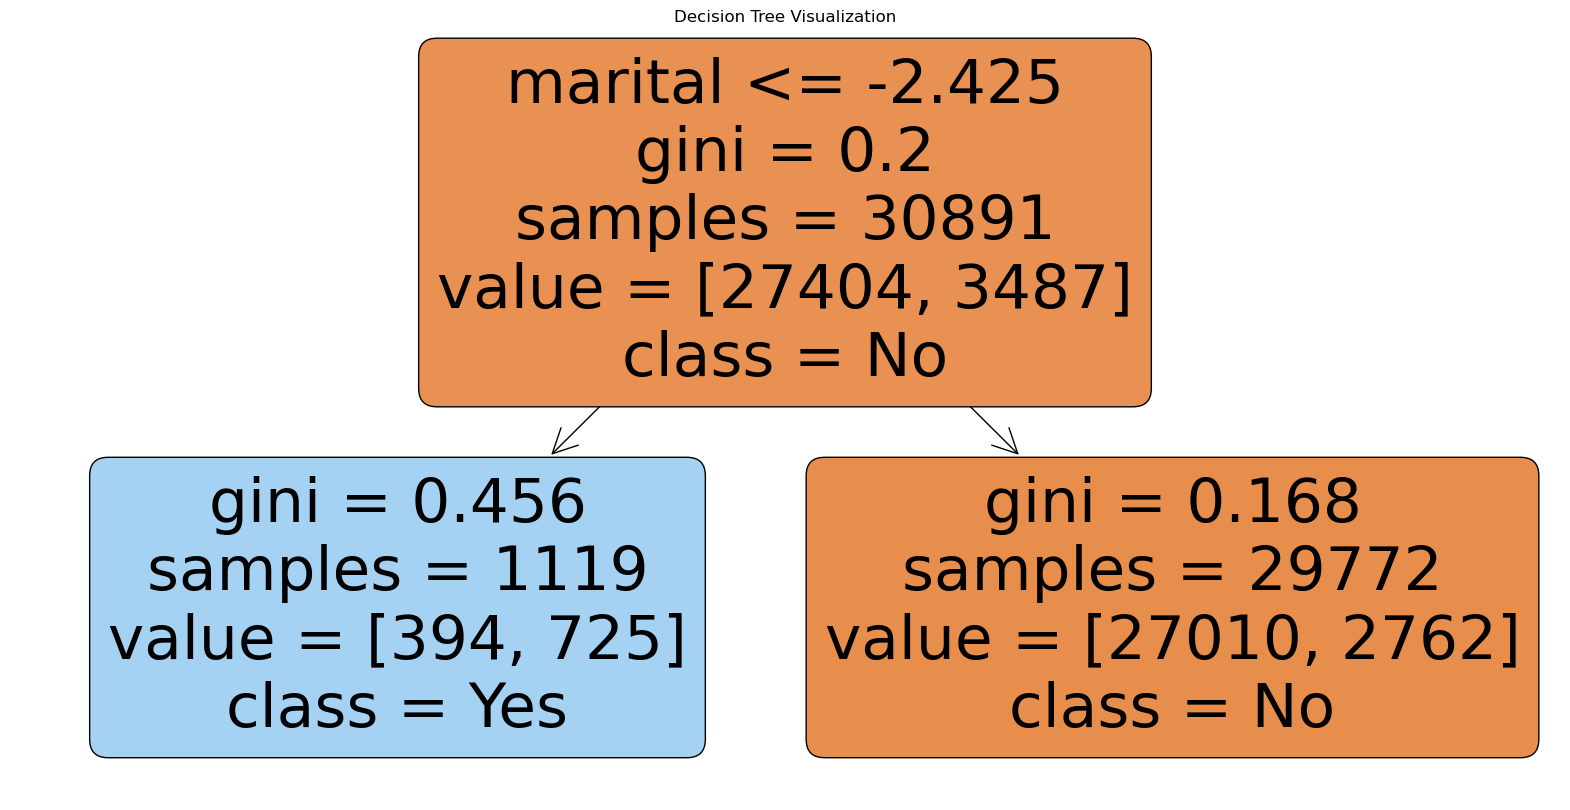

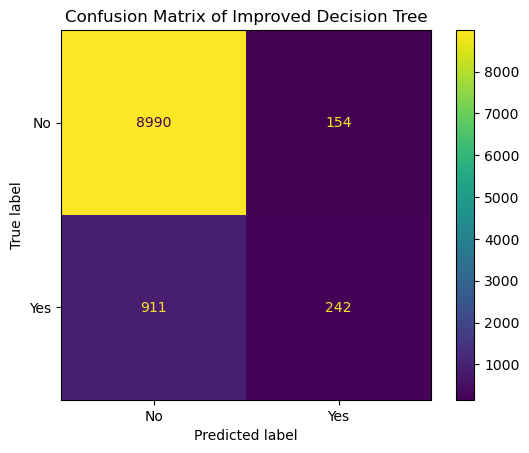

In [54]:
# Visualizing the simplified decision tree
plt.figure(figsize=(20, 10))
plot_tree(dtc_grid.best_estimator_['dtc'], feature_names=X_test.columns,  class_names=['No', 'Yes'], filled=True, rounded=True)
plt.title("Decision Tree Visualization")
plt.show()

# Confusion Matrix Visualization
y_pred = dtc_grid.best_estimator_.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
cm_display =ConfusionMatrixDisplay(conf_matrix, display_labels=["No","Yes"])
cm_display.plot()
plt.title("Confusion Matrix of Improved Decision Tree")
plt.show()

#### Support Vector Machine (SVM) 

In [56]:
#Build pipeline
params = {'svc__kernel': ['rbf', 'poly']}
svc_pipe = Pipeline([
         ("preprocessor", preprocessor),
         ("svc",SVC())])

# Modeling with GridSearch and train
svc_grid = GridSearchCV(estimator=svc_pipe, param_grid={}).fit(X_train, y_train)

In [57]:
#Add results to dataframe
svc_results = ["SVM", round(svc_grid.cv_results_['mean_fit_time'].mean(),6),
round(svc_grid.best_estimator_.score(X_train, y_train),6),
round(svc_grid.best_estimator_.score(X_test, y_test),6)]

improvedmodel_df.loc[len(improvedmodel_df)] =  svc_results
improvedmodel_df

,Model,Train Time,Train Accuracy,Test Accuracy
0,Logistic Regression,0.016275,0.897996,0.896863
1,KNN,0.015870,0.900165,0.894630
2,Decision Tree,0.015409,0.897834,0.896572
3,SVM,5.282766,0.898288,0.896960


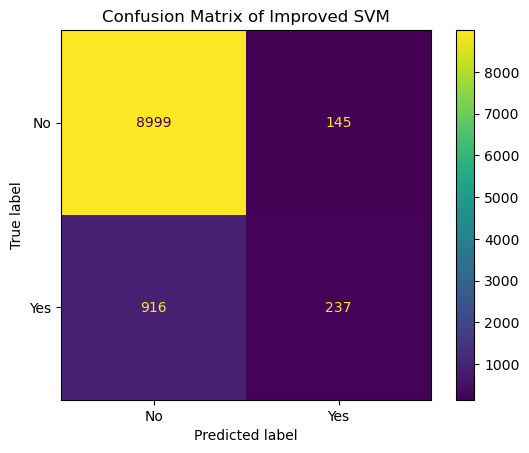

In [58]:
# Confusion Matrix
y_pred = svc_grid.best_estimator_.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
cm_display =ConfusionMatrixDisplay(conf_matrix, display_labels=["No","Yes"])
cm_display.plot()
plt.title("Confusion Matrix of Improved SVM")
plt.show()

## Comparison of Improved Model Results

In [60]:
#Changing the index
improvedmodel_df.set_index("Model", inplace=True)

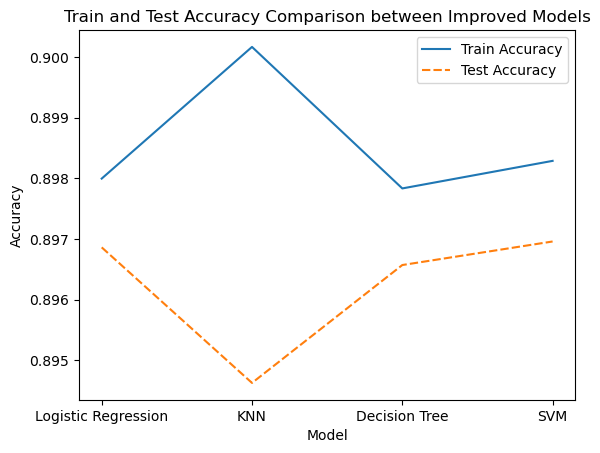

In [61]:
#Accuracy Visualization
fig = sns.lineplot(data=improvedmodel_df.drop(columns="Train Time"))
plt.title("Train and Test Accuracy Comparison between Improved Models")
plt.ylabel("Accuracy")
plt.show()

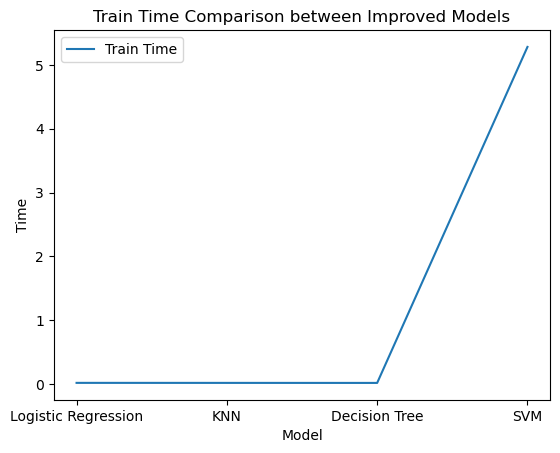

In [62]:
#Train Time Visualization
fig = sns.lineplot(data=improvedmodel_df[["Train Time"]])
plt.title("Train Time Comparison between Improved Models")
plt.ylabel("Time")
plt.show()